In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from enum import Enum, IntEnum

import numpy as np
import pandas as pd
from torch import nn
from torchsummary import summary
import torch
print (f'torch.__version__: {torch.__version__}')
import cv2 as cv
from torchvision import transforms
import pickle

import enums
import viz
import configuration
import customdataset
import transformers
import models
import feature_helpers
import model_analyzers
from utilmethods import create_output_folders, check_torch_mps_device, make_torch_deterministic

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from hyperopt import STATUS_OK,rand, tpe, Trials, fmin, hp
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import cross_val_score

from tqdm.notebook import tqdm
from models import optimize

# check_torch_mps_device()
# device = 'cpu'
# device = 'mps'

config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)

LABELS_TO_INCLUDE = config.class_dict.keys()
# LABELS_TO_INCLUDE=[0,1,2,9]

TRAIN_IMAGE_TYPES = [enums.ImageTypes.ORIGINAL, enums.ImageTypes.POSE_ANNOTATED, enums.ImageTypes.FACE]
TRAIN_FEATURES = [enums.FeatureType.CNN, enums.FeatureType.KEYPOINTS, enums.FeatureType.HOG]

torch.__version__: 1.13.0


In [9]:
%%time
# Load the data
data = feature_extractor.load_data(image_types=TRAIN_IMAGE_TYPES, 
                                   labels=LABELS_TO_INCLUDE, 
                                   shuffle=True, 
                                   sample_type=enums.SampleType.TRAIN_VALIDATION,
                                   count_per_label=540,
                                   include_feature_vectors=False)
y = data[enums.DataColumn.LABEL.value]
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=config.SEED)

# Load CNN and Keypoints features
all_features = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, 
                                                      data[enums.DataColumn.FILENAME.value], 
                                                      data[enums.DataColumn.LABEL.value],
                                                      features=set(TRAIN_FEATURES))
[cnn_features, hog_features, keypoints_features, _, _] = all_features


Loading 5400 samples:   0%|          | 0/5400 [00:00<?, ?samples/s]

Loading feature vectors:   0%|          | 0/5400 [00:00<?, ?images/s]

CPU times: user 27min 47s, sys: 2min 16s, total: 30min 3s
Wall time: 5min 30s


In [6]:
# Summarize data and features loaded.
print(f'Loaded {data.shape[0]} samples with {data.columns} columns.')
print(f'cnn_features:{cnn_features.shape}, cnn_features.min:{np.min(cnn_features)}, cnn_features.max:{np.max(cnn_features)}')
print(f'keypoints_features:{keypoints_features.shape}, keypoints_features.min:{np.min(keypoints_features)}, keypoints_features.max:{np.max(keypoints_features)}')
print(f'hog_features:{hog_features.shape}, hog_features.min:{np.min(hog_features)}, hog_features.max:{np.max(hog_features)}')
print(f'Training dataset size: {len(train_idx)}; Validation dataset size: {len(val_idx)}')
print()

Loaded 5400 samples with Index(['filename', 'label', 'original', 'pose_annotated', 'face'], dtype='object') columns.
cnn_features:(5400, 5776), cnn_features.min:0.0, cnn_features.max:1.0
keypoints_features:(5400, 26), keypoints_features.min:-0.5003660321235657, keypoints_features.max:0.9989637667923688
hog_features:(5400, 2048), hog_features.min:0.0, hog_features.max:1.607669472694397
Training dataset size: 4320; Validation dataset size: 1080



## Principal Components

In [78]:
# Helpers for vizualizing
def plot_PCA(X_list, names, n_components, max_components, out_file='pca.jpg', ):
    pca_list, xpca_list = feature_extractor.get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'g-', 'r-', 'k-', 'y-']
    plot_labels = [f'{name} features' for name in names]
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=plot_labels[i])
    # plt.xticks(np.arange(max_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(visible=True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.title('Explaining Power Of Principal Components')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=None, rect=None)
    plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
    plt.show()

def plot_classes(X, y, ax, title, included_labels):
    colormap = plt.cm.gist_rainbow # hsv tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
    markers = ['o', 'v', 's', 'p', 'x', '>', '*', '<', 'P', '^']
    for k, label in enumerate(included_labels):
        marker = markers[k % len(markers)]
        if X.shape[1] == 2:
            ax.scatter(X[y==label, 0], X[y==label, 1], facecolors=colorst[k], marker=marker, label=config.class_dict[label])
        else:
            ax.scatter(X[y==label, 0], X[y==label, 1], X[y==label, 2], facecolors=colorst[k], marker=marker, label=config.class_dict[label])
    ax.set_title(title)
    
def plot_components(features_list, X_pcas, X_tsnes, names, included_labels=LABELS_TO_INCLUDE, out_file='clustering.jpg'):
    # project the features into 2 dimensions
    fig, ax = plt.subplots(nrows=len(features_list), ncols=2, figsize=(5 * len(features_list), 15))
    if len(features_list) == 1:
        ax = [ax]

    # y is the class labels
    for i in range(len(features_list)):
        plot_classes(X_pcas[i], y, ax[i][0], title=f'{names[i]} PCA', included_labels=LABELS_TO_INCLUDE)
        plot_classes(X_tsnes[i], y, ax[i][1], title=f'{names[i]} tSNE', included_labels=LABELS_TO_INCLUDE)
    
    handles, plot_labels = ax[0][0].get_legend_handles_labels()
    fig.legend(handles, plot_labels, loc='upper center')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=12, rect=None)
    plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
    plt.show()

Doing PCA([200, 26, 200]):   0%|          | 0/3 [00:00<?, ?images/s]

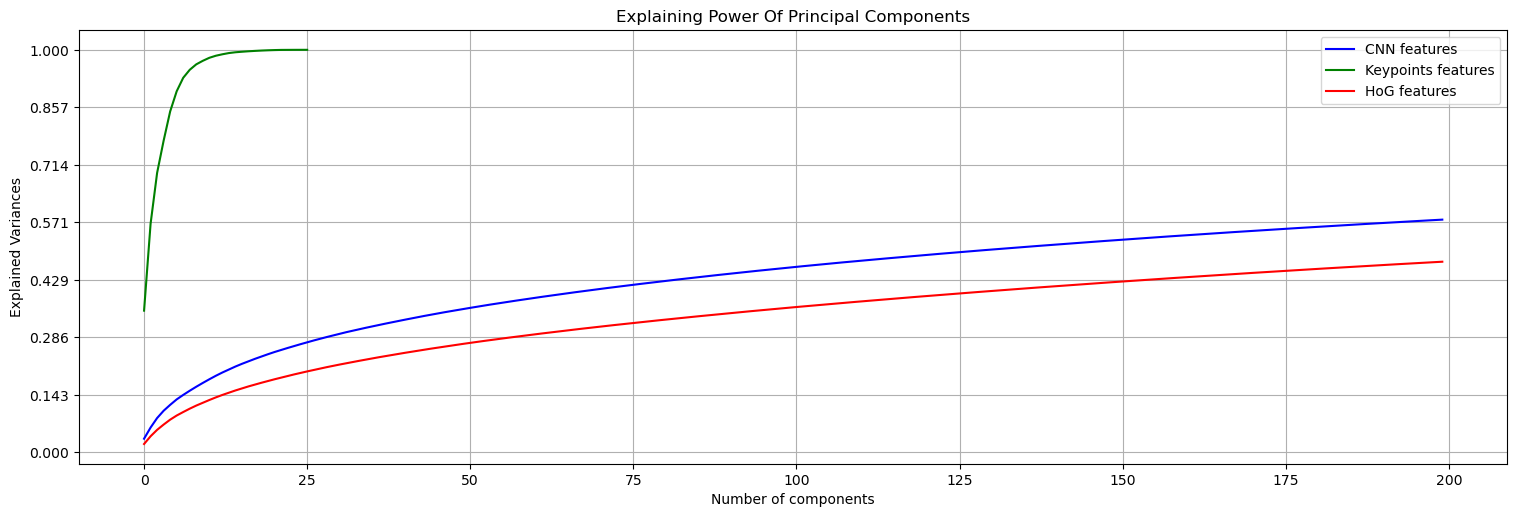

CPU times: user 8.18 s, sys: 203 ms, total: 8.38 s
Wall time: 1.8 s


In [75]:
%%time
plot_PCA([cnn_features, keypoints_features, hog_features], ['CNN', 'Keypoints', 'HoG'], n_components=[200, 26, 200], max_components=200, out_file=f'pca_cnn_hog_keypoints.jpg')

Doing PCA([2, 2, 2]):   0%|          | 0/3 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/3 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


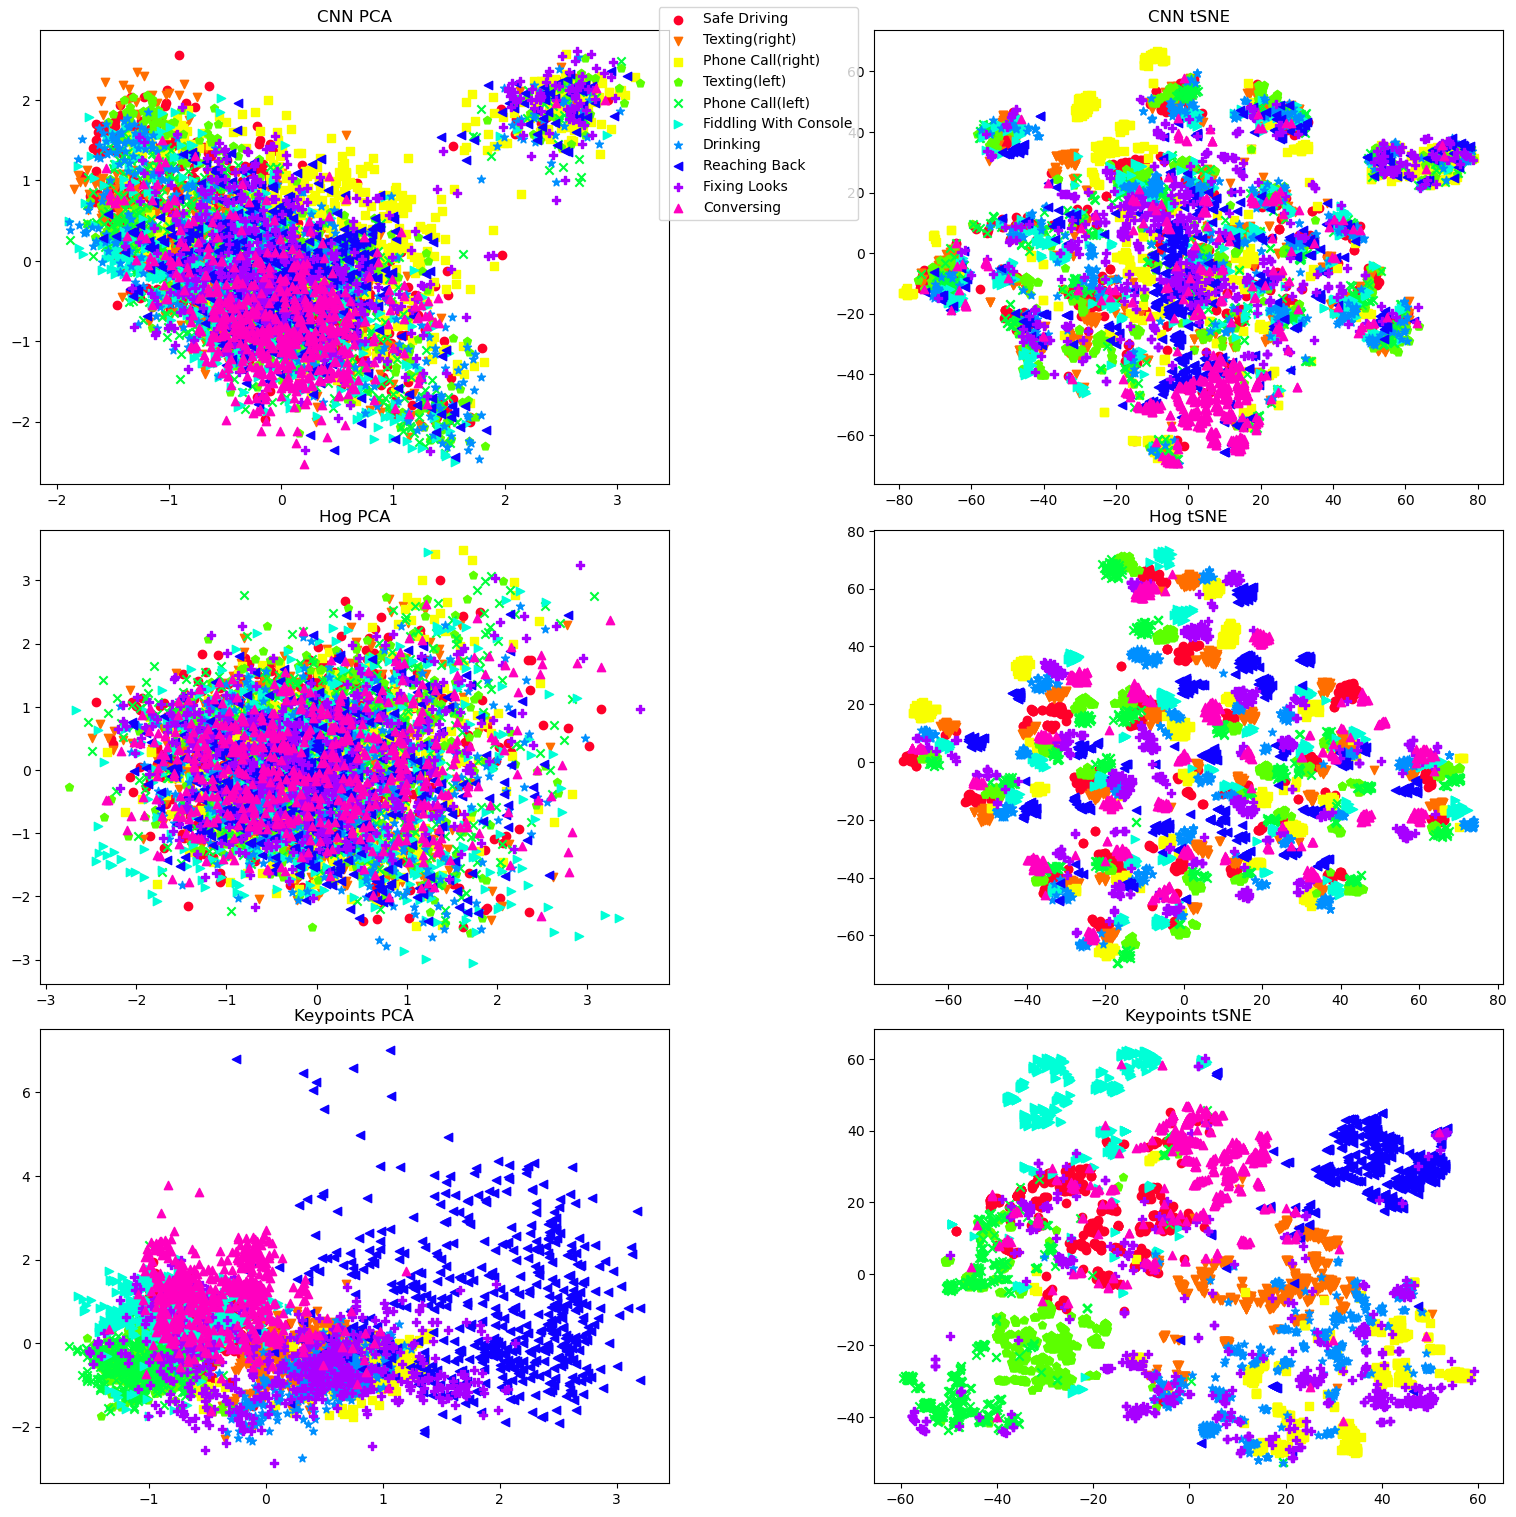

CPU times: user 4min 22s, sys: 4.57 s, total: 4min 26s
Wall time: 47.4 s


In [79]:
%%time
def visualize_components():
    features_list = [cnn_features, hog_features, keypoints_features]
    n_components = [2, 2, 2]
    names = ['CNN', 'Hog', 'Keypoints']
    pcas = feature_extractor.get_PCA(features_list, n_components)[-1]
    tsnes = feature_extractor.get_tsne(features_list, n_components=2)
    plot_components(features_list, pcas, tsnes, names, included_labels=LABELS_TO_INCLUDE)
visualize_components()

## KNN Classification

In [6]:
%%time
def run_knn(features, y, n_samples):
    def calc_accuracy(pca, y_train, idx, model_name):
        knn = KNeighborsClassifier(n_neighbors = 3)
        knn.fit(pca, y_train)
        filename = f'{config.SAVED_MODELS_FOLDER}/knn_{model_name}.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(knn, file)

        accuracy = 0

        for i in idx:
            label = knn.predict([pca[i,:]])
            if label[0] == y_train[i]:
                accuracy +=1
        return accuracy


    y_train = y[train_idx].tolist()
    idx = list(np.random.choice(np.arange(len(y_train)), n_samples, replace=False))

    # Get the principal components
    [pca_model], [X_keypoints_pca] = feature_extractor.get_PCA([features], n_components=[14])
    filename = f'{config.SAVED_MODELS_FOLDER}/pca_for_knn_keypoints_pca.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(pca_model, file)

    X_keypoints_pca = X_keypoints_pca[train_idx]

    [X_keypoints_tsne] = feature_extractor.get_tsne([features], n_components=2)
    X_keypoints_tsne = X_keypoints_tsne[train_idx]

    print(f'Accuracies from {n_samples} training samples:')
    print('Keypoints PCA Accuracy: ', calc_accuracy(X_keypoints_pca, y_train, idx, 'keypoints_pca')/n_samples)
    print('Keypoints tSNE Accuracy: ', calc_accuracy(X_keypoints_tsne, y_train, idx, 'keypoints_tsne')/n_samples)

run_knn(keypoints_features, y, 1000)

Doing PCA([14]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/1 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracies from 1000 training samples:
Keypoints PCA Accuracy:  0.943
Keypoints tSNE Accuracy:  0.936
CPU times: user 1min 50s, sys: 1.61 s, total: 1min 52s
Wall time: 20.1 s


## Logistic Regression

### Create Model

In [40]:
def train_classifier(in_feat, in_y, in_train_idx, val_idx):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # classifier with cross validation
    
    # 1e-5, 1e-4, 1e-3, ..., 1, 10, 100,
    param_grid = {"C": loguniform(1e-3, 1e5)}
    # clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=config.SEED), param_grid, n_iter=100)
    clf = RandomizedSearchCV(LogisticRegression(penalty='l1', max_iter=5000, solver='saga', random_state=config.SEED), param_grid, n_iter=10)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    return metrics.accuracy_score(y_val, y_pred)

def plot_accuracy_graph(keypoints_acc, n_components, out_file='keypoints_logit_accuracy.jpg'):
    # plot the accuracy graph
    plt.figure(figsize=(15,5))
    # plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
    # plt.plot(np.array(pose_acc)*100, 'g-', label='pose features')
    # plt.plot(np.array(CNN_acc)*100, 'k-', label='CNN features')

    for i in np.array(keypoints_acc).shape[1]:
        plt.plot(np.array(keypoints_acc[i])*100, 'b-', label='keypoints features')


    xtick_labels = [f'{i+1}' for i in n_components] + ['All']
    plt.xticks(np.arange(len(n_components) + 1), labels=xtick_labels)
    plt.yticks(np.linspace(0, 100, 11))
    plt.grid(b=True)
    plt.xlabel('Number of components')
    plt.ylabel('Accuracy')
    # plt.ylim([0, 100])
    plt.legend()
    plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
    plt.show()
    
def train_and_check(features, n_components, name, y, train_idx, val_idx):
    pbar = tqdm(desc=name, total=len(n_components) + 1, position=0, leave=True)
    acc = []
    for n in n_components:
        pbar.set_description(f'{name}: Computing PCA({n})')
        _, X = feature_extractor.get_PCA([features], n_components=[n+1])
        acc.append(train_classifier(X[0], y, train_idx, val_idx))
        pbar.update(1)
    pbar.set_description(f'{name}: Training classifier')
    acc.append(train_classifier(features, y, train_idx, val_idx))
    pbar.update(1)
    pbar.close()
    plot_accuracy_graph(acc, n_components)
    return acc

Keypoints Feature Accuracy


Keypoints:   0%|          | 0/7 [00:00<?, ?it/s]

Doing PCA([2]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([6]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([11]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([16]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([21]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([24]):   0%|          | 0/1 [00:00<?, ?images/s]

/var/folders/s4/p0y554f56hd_d9fk8y79dy3c0000gs/T/ipykernel_13026/2443562878.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


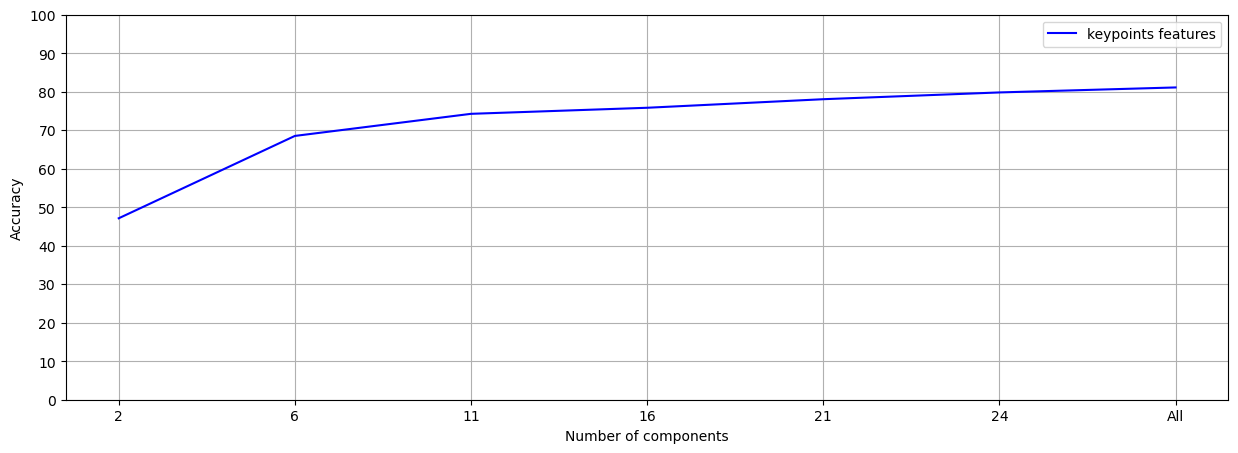

CPU times: user 25min 38s, sys: 9.17 s, total: 25min 47s
Wall time: 22min 15s


[0.47129629629629627,
 0.6851851851851852,
 0.7425925925925926,
 0.7583333333333333,
 0.7805555555555556,
 0.7981481481481482,
 0.8111111111111111]

In [105]:
%%time

print('Keypoints Feature Accuracy')
train_and_check(keypoints_features, [1, 5, 10, 15, 20, 23], 'Keypoints', y, train_idx, val_idx)


In [131]:
def logit_classifier(features, y, train_idx, val_idx, grid_params, feature_name, 
                     model_name, max_iter=5000, penalty='l1', solver='saga', scoring='neg_log_loss'):
    # get the train and validation split
    X_train = features[train_idx, :].copy()
    y_train = y[train_idx].copy()
    X_val = features[val_idx, :].copy()
    y_val = y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Save scaler for inference time use.
    pickle.dump(scaler, open(f'{config.SAVED_MODELS_FOLDER}/scaler_{model_name}_{feature_name}.pkl','wb'))

    # classifier with cross validation
    clf = RandomizedSearchCV(LogisticRegression(penalty=penalty, solver=solver, random_state=config.SEED, max_iter=max_iter),
                       grid_params, return_train_score=True, scoring=scoring)
    clf = clf.fit(X_train, y_train)

    # Save the trained model for inference time.
    pickle.dump(clf, open(f'{config.SAVED_MODELS_FOLDER}/model_{model_name}_{feature_name}.pkl', 'wb'))
    
    y_pred = clf.predict(X_val)
    return clf, metrics.accuracy_score(y_val, y_pred)

def create_lr_keypoints_pca_model():
    n_components = 16
    # Parameter space for random search hyper parameter tuning.
    grid_params = {
        'C': loguniform(1e-2, 1e3)}

    # Random search of hyper parameters
    [keypoints_pca],[X_keypoints_pca] = feature_extractor.get_PCA([keypoints_features], n_components=[n_components])
    print(len(X_keypoints_pca))
    
    #save the PCA for inference time use
    pickle.dump(keypoints_pca, open(f'{config.SAVED_MODELS_FOLDER}/model_pca_{n_components}_keypoints_pca.pkl', 'wb'))
    logit_pca_clf, logit_pca_accuracy = logit_classifier(X_keypoints_pca, y, train_idx, val_idx, grid_params, 'keypoints_pca', 'logistic')
    
def create_lr_keypoints_model():
    # Parameter space for random search hyper parameter tuning.
    grid_params = {
        'C': loguniform(1e-2, 1e3)}
    logit_pca_clf, logit_pca_accuracy = logit_classifier(keypoints_features, y, train_idx, val_idx, grid_params, 'keypoints', 'logistic')


In [132]:
%%time

# Train the logistic regression model with 16 principal components of pose based features
create_lr_keypoints_pca_model()


Doing PCA([16]):   0%|          | 0/1 [00:00<?, ?images/s]

5400
CPU times: user 2min 29s, sys: 1.1 s, total: 2min 30s
Wall time: 1min 42s


In [ ]:
%%time

# Train the logistic regression model with the 26 pose based features
create_lr_keypoints_model()

### Create Random Forest

In [10]:
%%time

def train_classifiers_with_hyperopt(in_feat, in_y, in_train_idx, val_idx, feature_name):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # classifier with cross validation
    best_dict = {}
    param_grid = {
        # 'logistic_regression': {
        #     'model': LogisticRegression,
        #     'params': {
        #         'penalty': 'elasticnet',
        #         'solver': 'saga',
        #         'max_iter': 5000,
        #         'C': hp.uniform('C', 50, 200),
        #         'l1_ratio': hp.uniform('l1_ratio', 0.3, 0.9)
        #     }
        # },
        'random_forest': {
            'model': RandomForestClassifier,
            'params': {
                    'max_depth': 1 + hp.randint('max_depth', 20),
                    'n_estimators': 1 + hp.randint('n_estimators', 300),
                    'n_jobs': 4
            }
        }
    }
    # Optimize and output best hyperparameter set for each model
    best_dict = optimize(opt_dict = param_grid,
                         best_dict = best_dict,
                         X_train = X_train,
                         y_train = y_train,
                         max_evals = 100)
    
    # clf_lr = LogisticRegression(random_state = config.SEED, **best_dict['logistic_regression'])
    # clf_lr = clf_lr.fit(X_train, y_train)
    # y_pred_lr = clf_lr.predict(X_val)
    # pickle.dump(clf_lr, open(f'{config.SAVED_MODELS_FOLDER}/model_lr_hyperopt_{feature_name}.pkl', 'wb'))    

    clf_rf = RandomForestClassifier(random_state = config.SEED, **best_dict['random_forest'])
    clf_rf = clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_val)
    pickle.dump(clf_rf, open(f'{config.SAVED_MODELS_FOLDER}/model_rf_{feature_name}.pkl', 'wb'))    
    
    # return accuracy_score(y_val, y_pred_lr), accuracy_score(y_val, y_pred_rf), clf_lr, clf_rf
    return accuracy_score(y_val, y_pred_rf), clf_rf

train_classifiers_with_hyperopt(keypoints_features, y, train_idx, val_idx, 'keypoints')

Optimizing random_forest model...
  2%|██▎                                                                                                                   | 2/100 [00:05<04:52,  2.98s/trial, best loss: 0.407015897584858]
Best hyperparameter set for random_forest is {'max_depth': 15, 'n_estimators': 172}


CPU times: user 3.52 s, sys: 931 ms, total: 4.45 s
Wall time: 8.59 s


(0.9166666666666666,
 RandomForestClassifier(max_depth=15, n_estimators=172, random_state=42))

### Test Against Validation Dataset

KNN Using Keypoints PCA against Validation Dataset
Model Summary:
KNeighborsClassifier(n_neighbors=3)
Model Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       121
           1       0.93      0.98      0.95       113
           2       0.94      0.98      0.96       120
           3       0.99      0.99      0.99        97
           4       0.94      0.97      0.96       106
           5       1.00      0.97      0.99       104
           6       0.90      0.96      0.93       101
           7       0.99      0.98      0.99       110
           8       0.99      0.74      0.85       101
           9       0.97      0.93      0.95       107

    accuracy                           0.95      1080
   macro avg       0.95      0.95      0.95      1080
weighted avg       0.95      0.95      0.95      1080

Model Accuracy: 0.950925925925926


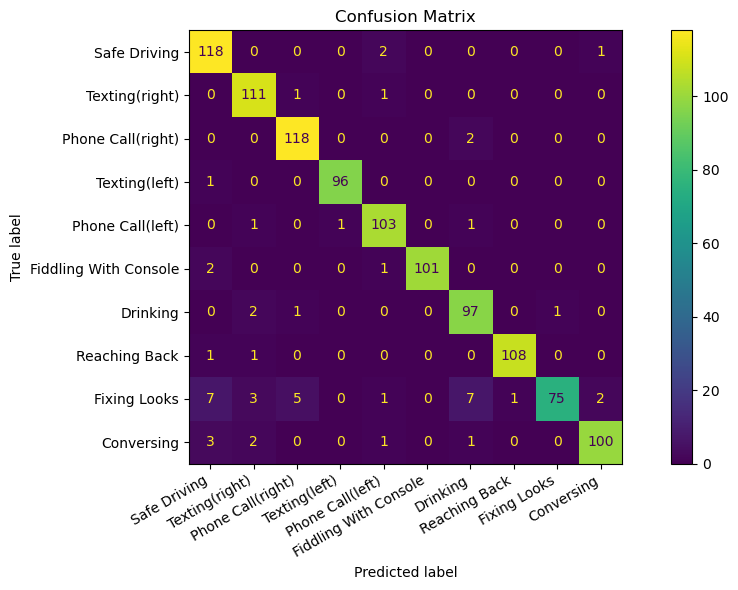

Logistic Regression Using Keypoints PCA against Validation Dataset
Model Summary:
RandomizedSearchCV(estimator=LogisticRegression(max_iter=5000, penalty='l1',
                                                random_state=42,
                                                solver='saga'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f9804661b50>},
                   return_train_score=True, scoring='neg_log_loss')
Best Parameters:
{'C': 9.500367606892183}
Model Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.74       121
           1       0.93      0.90      0.91       113
           2       0.81      0.80      0.80       120
           3       0.78      0.78      0.78        97
           4       0.74      0.74      0.74       106
           5       0.85      0.81      0.83       104
           6       0.76      0.77      0.76       101
           

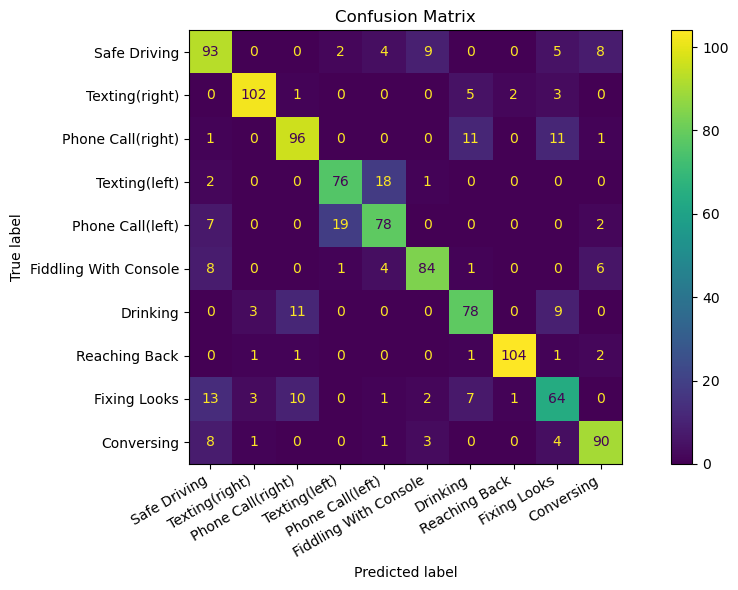

Logistic Regression Using Keypoints against Validation Dataset
Model Summary:
RandomizedSearchCV(estimator=LogisticRegression(max_iter=5000, penalty='l1',
                                                random_state=42,
                                                solver='saga'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f98dd423850>},
                   return_train_score=True, scoring='neg_log_loss')
Best Parameters:
{'C': 0.9298100196708735}
Model Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       121
           1       0.90      0.92      0.91       113
           2       0.86      0.85      0.85       120
           3       0.82      0.92      0.86        97
           4       0.87      0.78      0.83       106
           5       0.89      0.87      0.88       104
           6       0.76      0.80      0.78       101
           7  

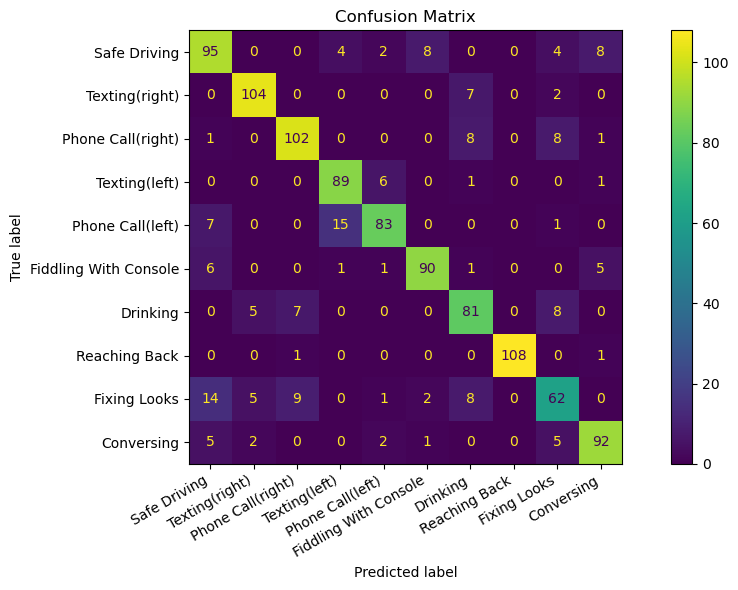

Random Forest Using Keypoints against Validation Dataset
Model Summary:
RandomForestClassifier(max_depth=15, n_estimators=172, random_state=42)
Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       121
           1       0.91      0.97      0.94       113
           2       0.93      0.97      0.95       120
           3       0.95      0.97      0.96        97
           4       0.94      0.95      0.94       106
           5       0.95      0.95      0.95       104
           6       0.90      0.92      0.91       101
           7       0.98      0.96      0.97       110
           8       0.91      0.63      0.75       101
           9       0.92      0.93      0.92       107

    accuracy                           0.92      1080
   macro avg       0.92      0.92      0.92      1080
weighted avg       0.92      0.92      0.92      1080

Model Accuracy: 0.9175925925925926


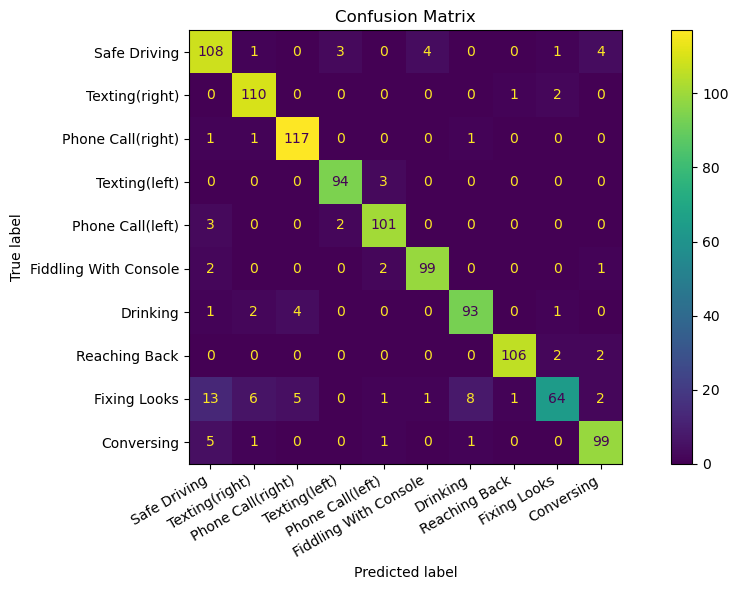

In [11]:
_ = model_analyzers.ModelSummarizer(config).evaluate_models_against('Validation', keypoints_features[val_idx, :], y[val_idx])

### Test Against Holdout Dataset

Loading 600 samples:   0%|          | 0/600 [00:00<?, ?samples/s]

Loading feature vectors:   0%|          | 0/600 [00:00<?, ?images/s]

KNN Using Keypoints PCA against Holdout Dataset
Model Summary:
KNeighborsClassifier(n_neighbors=3)
Model Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        60
           1       0.87      0.97      0.91        60
           2       0.81      0.93      0.87        60
           3       0.90      0.90      0.90        60
           4       0.91      0.87      0.89        60
           5       0.97      0.98      0.98        60
           6       0.85      0.93      0.89        60
           7       0.98      0.93      0.96        60
           8       1.00      0.57      0.72        60
           9       0.85      0.88      0.87        60

    accuracy                           0.89       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600

Model Accuracy: 0.89


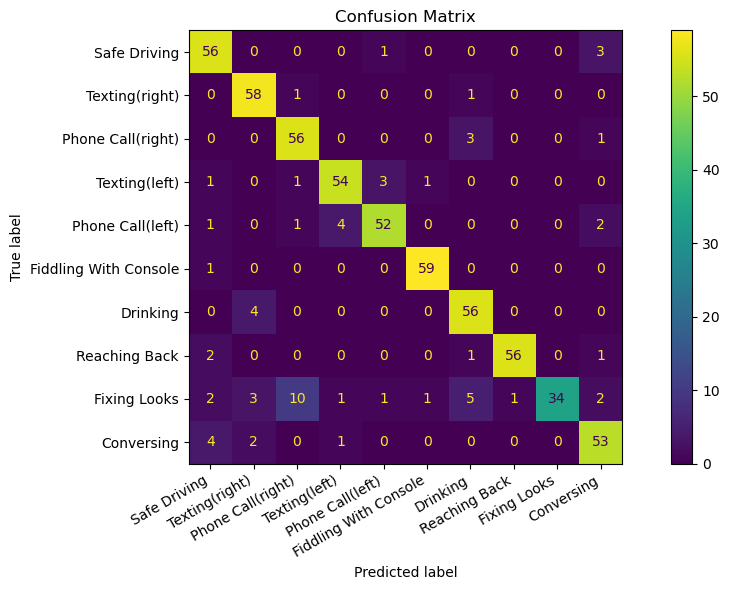

Logistic Regression Using Keypoints PCA against Holdout Dataset
Model Summary:
RandomizedSearchCV(estimator=LogisticRegression(max_iter=5000, penalty='l1',
                                                random_state=42,
                                                solver='saga'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8efe214730>},
                   return_train_score=True, scoring='neg_log_loss')
Best Parameters:
{'C': 9.500367606892183}
Model Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        60
           1       0.84      0.88      0.86        60
           2       0.70      0.80      0.74        60
           3       0.77      0.80      0.79        60
           4       0.75      0.73      0.74        60
           5       0.96      0.87      0.91        60
           6       0.74      0.72      0.73        60
           7  

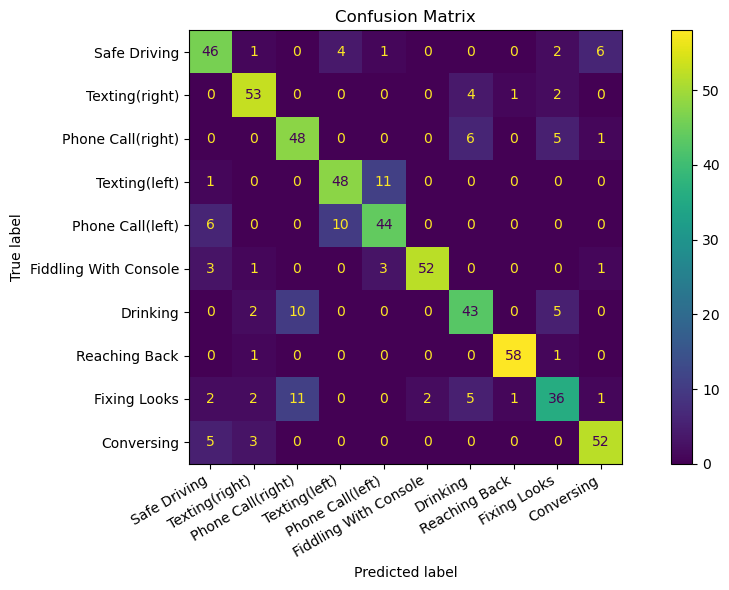

Logistic Regression Using Keypoints against Holdout Dataset
Model Summary:
RandomizedSearchCV(estimator=LogisticRegression(max_iter=5000, penalty='l1',
                                                random_state=42,
                                                solver='saga'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8e210ecdf0>},
                   return_train_score=True, scoring='neg_log_loss')
Best Parameters:
{'C': 0.9298100196708735}
Model Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        60
           1       0.85      0.92      0.88        60
           2       0.76      0.85      0.80        60
           3       0.82      0.85      0.84        60
           4       0.84      0.78      0.81        60
           5       0.91      0.88      0.90        60
           6       0.78      0.75      0.76        60
           7     

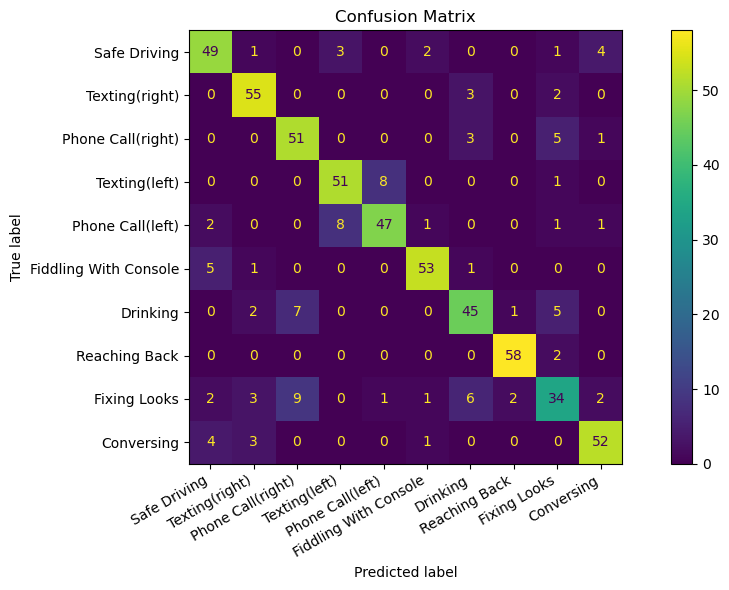

Random Forest Using Keypoints against Holdout Dataset
Model Summary:
RandomForestClassifier(max_depth=15, n_estimators=172, random_state=42)
Model Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        60
           1       0.92      1.00      0.96        60
           2       0.92      0.95      0.93        60
           3       0.87      0.92      0.89        60
           4       0.89      0.83      0.86        60
           5       0.97      0.97      0.97        60
           6       0.84      0.90      0.87        60
           7       0.95      0.98      0.97        60
           8       0.86      0.62      0.72        60
           9       0.89      0.90      0.89        60

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.89       600
weighted avg       0.90      0.90      0.89       600

Model Accuracy: 0.8966666666666666


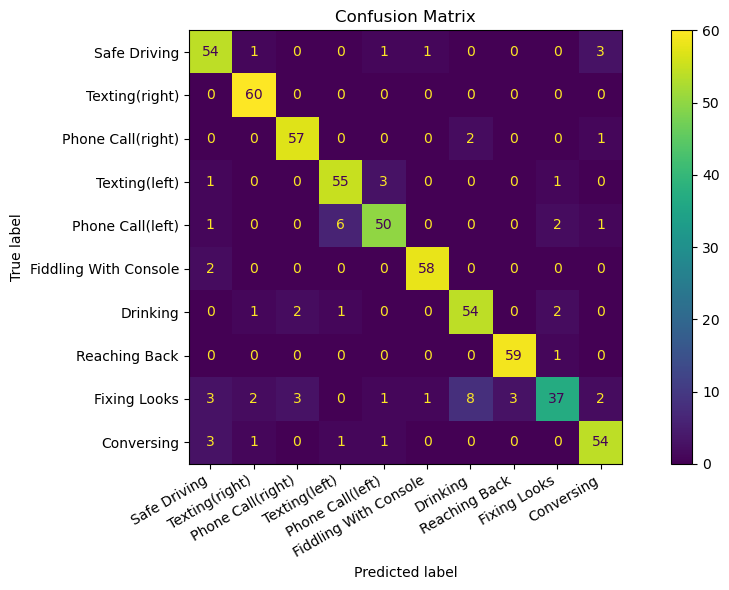

Saved


In [38]:
def display_misclassified_images(data_holdout, y_holdout, predictions_map):
    # {
    #         'knn_pca16': knn_pca16_y_pred,
    #         'lr_pca16': lr_pca16_y_pred,
    #         'lr_keypoints': lr_keypoints_y_pred,
    #         'rf_keypoints': rf_y_pred
    # }
    (knn_pca16_y_pred, knn_pca16_acc) = predictions_map['knn_pca16']
    final_data = data_holdout[['filename', 'label']].copy()
    names = ['filename', 'truth']
    for name in predictions_map:
        # final_data[f'pred_{name}'] = predictions_map[name]
        final_data = np.append(final_data, predictions_map[name][0].reshape(-1, 1), 1)
        names.append(name)
    
    
    final_data_pd = pd.DataFrame(final_data, columns=names)
    final_data_pd.to_csv('final_predictions_heldout_dataset.csv')
    print('Saved')
    
def test_models_against_holdout():
    data_holdout = feature_extractor.load_data(image_types=TRAIN_IMAGE_TYPES,
                                   labels=LABELS_TO_INCLUDE,
                                   shuffle=True, 
                                   sample_type=enums.SampleType.TEST,
                                   include_feature_vectors=False)
    y_holdout = data_holdout[enums.DataColumn.LABEL.value]

    # Load CNN and Keypoints features
    all_features = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, 
                                                          data_holdout[enums.DataColumn.FILENAME.value], 
                                                          data_holdout[enums.DataColumn.LABEL.value],
                                                          features=set(TRAIN_FEATURES))
    [holdout_cnn_features, _, holdout_keypoints_features, _, _] = all_features
    model_summarizer = model_analyzers.ModelSummarizer(config)
    predictions_map = model_summarizer.evaluate_models_against('Holdout',
                                                               holdout_keypoints_features,
                                                               y_holdout)
    # summary = model_summarizer.generate_sumamry(predictions_map)
    display_misclassified_images(data_holdout, y_holdout, predictions_map)

test_models_against_holdout()

In [ ]:
# print(data_holdout.shape, y_holdout.shape, predictions_map)
# print(predictions_map['knn_pca16'][0].shape)



Index(['filename', 'truth', 'knn_pca16', 'lr_pca16', 'lr_keypoints',
       'rf_keypoints'],
      dtype='object')
